In [ ]:
#Program 1 (Find S)
import pandas as pd

data = pd.read_csv("EnjoySport.csv", header = None)
print(data)

numberAttributes = len(data.columns) - 1
hypothesis = ['0' for _ in range(numberAttributes)]

print("Intial Hypothesis : ", hypothesis)
for index, row in data.iterrows():
    if row[len(row)-1] == "Yes":
        for colIndex in range(len(row)-1):
            if hypothesis[colIndex] == '0':
                hypothesis[colIndex] = row[colIndex]
            elif hypothesis[colIndex] != row[colIndex]:
                hypothesis[colIndex] = '?'
        print("Hypothesis {} : {}".format(index + 1, hypothesis))

print("Final Hypothesis: ", hypothesis)

       0     1       2       3     4       5    6
0  Sunny  Warm  Normal  Strong  Warm    Same  Yes
1  Sunny  Warm    High  Strong  Warm    Same  Yes
2  Rainy  Cold    High  Strong  Warm  Change   No
3  Sunny  Warm    High  Strong  Cool  Change  Yes
Intial Hypothesis :  ['0', '0', '0', '0', '0', '0']
Hypothesis 1 : ['Sunny', 'Warm', 'Normal', 'Strong', 'Warm', 'Same']
Hypothesis 2 : ['Sunny', 'Warm', '?', 'Strong', 'Warm', 'Same']
Hypothesis 4 : ['Sunny', 'Warm', '?', 'Strong', '?', '?']
Final Hypothesis:  ['Sunny', 'Warm', '?', 'Strong', '?', '?']


In [2]:
# Program 2 (Candidate Elimination)

import pandas as pd

data = pd.read_csv("EnjoySport.csv", header = None)
print(data)

n = len(data.columns) - 1
s = ['0' for _ in range(n)]
g = [['?' for _ in range(n)]]

def consistencyOfG(row, generalHypothesisSet):
    newG = []
    for h in generalHypothesisSet:
        consistent = True
        for colIndex in range(len(h)):
            if h[colIndex] == '?':
                continue
            elif h[colIndex] != row[colIndex]:
                consistent = False
                break
        if consistent == True:
            newG.append(h)

    return newG

for index, row in data.iterrows():
    print("----------")
    print("Row {} : {} ".format(index+1, row.values))

    if row[len(row)-1] == "Yes":
        g = consistencyOfG(row,g)
        for colIndex in range(len(row)-1):
            if s[colIndex] == '0':
                s[colIndex] = row[colIndex]
            elif s[colIndex] != row[colIndex]:
                s[colIndex] = '?'
    else:
        newG = []
        moreGeneral = []
        for i in range(n):
            for h in g:
                if h[i] == '?' and s[i] != row[i]:
                    newH = list(h)
                    newH[i] = s[i]
                    newG.append(newH)
                    moreGeneral.append(h)

        for generalH in moreGeneral:
            if generalH in newG:
                newG.remove(generalH)

        g = newG

    print("Specific Hypothesis: ", s)
    print("General Hypothesis: ", g)

       0     1       2       3     4       5    6
0  Sunny  Warm  Normal  Strong  Warm    Same  Yes
1  Sunny  Warm    High  Strong  Warm    Same  Yes
2  Rainy  Cold    High  Strong  Warm  Change   No
3  Sunny  Warm    High  Strong  Cool  Change  Yes
----------
Row 1 : ['Sunny' 'Warm' 'Normal' 'Strong' 'Warm' 'Same' 'Yes'] 
Specific Hypothesis:  ['Sunny', 'Warm', 'Normal', 'Strong', 'Warm', 'Same']
General Hypothesis:  [['?', '?', '?', '?', '?', '?']]
----------
Row 2 : ['Sunny' 'Warm' 'High' 'Strong' 'Warm' 'Same' 'Yes'] 
Specific Hypothesis:  ['Sunny', 'Warm', '?', 'Strong', 'Warm', 'Same']
General Hypothesis:  [['?', '?', '?', '?', '?', '?']]
----------
Row 3 : ['Rainy' 'Cold' 'High' 'Strong' 'Warm' 'Change' 'No'] 
Specific Hypothesis:  ['Sunny', 'Warm', '?', 'Strong', 'Warm', 'Same']
General Hypothesis:  [['Sunny', '?', '?', '?', '?', '?'], ['?', 'Warm', '?', '?', '?', '?'], ['?', '?', '?', '?', '?', 'Same']]
----------
Row 4 : ['Sunny' 'Warm' 'High' 'Strong' 'Cool' 'Change' 'Yes'] 

In [3]:
# Program 3 (ID3 algorithm)

import pandas as pd
import math
from collections import Counter
from pprint import pprint

df = pd.read_csv("tennis.csv")
targetAttribute = 'PlayTennis'

def entropy(probs):
    return sum( [-prob*math.log(prob, 2) for prob in probs] )

def entropy_of_list(targetValues):
    counter = Counter(targetValues)
    numberInstances = len(targetValues)*1.0     
    probs = [x / numberInstances for x in counter.values()]
    return entropy(probs)

def information_gain(df, splitAttribute, targetAttribute, trace=0): 
    df_split = df.groupby(splitAttribute)
    nobs = len(df.index) * 1.0
    df_agg_ent = df_split.agg({targetAttribute : [entropy_of_list, lambda x: len(x)/nobs] })[targetAttribute] 
    df_agg_ent.columns = ['Entropy', 'PropObservations'] 
    new_entropy = sum(df_agg_ent['Entropy'] * df_agg_ent['PropObservations'] )
    old_entropy = entropy_of_list(df[targetAttribute]) 
    return old_entropy - new_entropy

def id3(df, targetAttribute, attributeNames, default_class=None):
    counter = Counter(x for x in df[targetAttribute])
    if len(counter) == 1:         
        return next(iter(counter)) 
    elif df.empty or (not attributeNames): 
             return default_class 
    else:
        gainz = [information_gain(df, attribute, targetAttribute) for attribute in attributeNames]
        index_of_max = gainz.index(max(gainz)) 
        best_attr = attributeNames[index_of_max] 
        tree = {best_attr:{}}
        remainingAttributeNames = [i for i in attributeNames if i != best_attr]
        for attr_val, data_subset in df.groupby(best_attr): 
            subtree = id3(data_subset,
                          targetAttribute,                         
                          remainingAttributeNames,                         
                          default_class)
            tree[best_attr][attr_val] = subtree 
        return tree


total_entropy = entropy_of_list(df[targetAttribute]) 
print("Entropy of given Data Set:",total_entropy)
print("-----------------")

attributeNames = list(df.columns)
print("List of Attributes:", attributeNames) 
attributeNames.remove(targetAttribute) 
print("Predicting Attributes:", attributeNames)
print("-----------------")

for attribute in attributeNames:
  informationGain = str(information_gain(df, attribute, targetAttribute))
  print('Info-gain for {} is : {}'.format(attribute, informationGain))
print("-----------------")

tree = id3(df,targetAttribute ,attributeNames)
print("\n\nThe Resultant Decision Tree is :\n") 
pprint(tree)

Entropy of given Data Set: 0.9402859586706309
-----------------
List of Attributes: ['Outlook', 'Temperature', 'Humidity', 'Windy', 'PlayTennis']
Predicting Attributes: ['Outlook', 'Temperature', 'Humidity', 'Windy']
-----------------
Info-gain for Outlook is : 0.2467498197744391
Info-gain for Temperature is : 0.029222565658954647
Info-gain for Humidity is : 0.15183550136234136
Info-gain for Windy is : 0.04812703040826927
-----------------


The Resultant Decision Tree is :

{'Outlook': {'Overcast': 'Yes',
             'Rainy': {'Windy': {False: 'Yes', True: 'No'}},
             'Sunny': {'Humidity': {'High': 'No', 'Normal': 'Yes'}}}}


In [ ]:
#Program 4 (Backpropogation):

import numpy as np
from numpy.random import rand, randint

inputNeurons = 2
hiddenLayerNeurons = 2
outputNeurons = 2

input_layer = randint(1,100,inputNeurons)

hidden_layer = rand(1,hiddenLayerNeurons)
hidden_bias = rand(1,hiddenLayerNeurons)
hidden_weights = rand(inputNeurons, hiddenLayerNeurons)

output = np.array([1,0])
output_bias = rand(1,outputNeurons)
output_weights = rand(hiddenLayerNeurons, outputNeurons)

def sigmoid(layer):
    return 1/(1 + np.exp(-layer))

def gradient(layer):
    return layer * (1 - layer)

iterations = 2000
for i in range(iterations):
    hidden_layer = np.dot(input_layer,hidden_weights)
    hidden_layer = sigmoid(hidden_layer+hidden_bias)

    output_layer = np.dot(hidden_layer,output_weights)
    output_layer = sigmoid(output_layer+output_bias)

    error = output - output_layer

    error_terms_output = gradient(output_layer) * error
    error_terms_hidden = gradient(hidden_layer) * np.dot(error_terms_output, output_weights.T)

    gradient_output_weights = np.dot(hidden_layer.reshape(hiddenLayerNeurons,1),
                                     error_terms_output.reshape(1,outputNeurons))

    gradient_hidden_weights = np.dot(input_layer.reshape(inputNeurons,1),
                                     error_terms_hidden.reshape(1,hiddenLayerNeurons))
    
    output_weights += (0.05 * gradient_output_weights)
    hidden_weights += (0.05 * gradient_hidden_weights)

    if i < 5 or i > iterations - 5:
        print("Iteration : ", i+1)
        print("Error: ", error)
        print("Output layer:", output_layer)

Iteration :  1
Error:  [[ 0.14508426 -0.86961955]]
Output layer: [[0.85491574 0.86961955]]
Iteration :  2
Error:  [[ 0.14486175 -0.86849816]]
Output layer: [[0.85513825 0.86849816]]
Iteration :  3
Error:  [[ 0.14464016 -0.8673618 ]]
Output layer: [[0.85535984 0.8673618 ]]
Iteration :  4
Error:  [[ 0.14441947 -0.86621024]]
Output layer: [[0.85558053 0.86621024]]
Iteration :  5
Error:  [[ 0.14419969 -0.86504327]]
Output layer: [[0.85580031 0.86504327]]
Iteration :  1997
Error:  [[ 0.05073906 -0.05818771]]
Output layer: [[0.94926094 0.05818771]]
Iteration :  1998
Error:  [[ 0.05072729 -0.05817024]]
Output layer: [[0.94927271 0.05817024]]
Iteration :  1999
Error:  [[ 0.05071553 -0.05815278]]
Output layer: [[0.94928447 0.05815278]]
Iteration :  2000
Error:  [[ 0.05070378 -0.05813534]]
Output layer: [[0.94929622 0.05813534]]


In [ ]:
# Program 5 (Naive Bayes Golf)
from pprint import pprint
import pandas as pd
from collections import Counter

df = pd.read_csv("golf.csv")
targetAttribute = "label"

attributes = list(df.columns)
attributes.remove(targetAttribute)

train = df.sample(frac=0.6,random_state=100)
test = df.drop(train.index)

table = dict()
priorProb = dict()

for attr_val, data_subset in train.groupby(targetAttribute):
    valueCount = dict()
    count = 0
    for attribute in attributes:
        counter = Counter(x for x in data_subset[attribute])
        valueCount[attribute] = dict(counter)
        count = sum(counter.values())
    table[attr_val] = valueCount
    priorProb[attr_val] = count

print("------------------------------")
print("The Resultant table is :")
pprint(table)

totalSize = test[targetAttribute].count()
correctPredictions = 0

for k, row in test.iterrows():

    rowTuple = dict(row)
    keyList = [x for x in rowTuple.keys() if x != targetAttribute]
    posterioriList = list()
    labelList = list()

    for label in table.keys():
        posteriori = 1.0
        for key in keyList:
            y = table[label][key]
            x = rowTuple.get(key)
            if x in y.keys():
                posteriori *= (y[x]/sum(y.values()))

        posteriori *= priorProb[label]
        labelList.append(label)
        posterioriList.append(posteriori)

    maxProbInd = posterioriList.index(max(posterioriList))
    if rowTuple[targetAttribute] == labelList[maxProbInd]:
        correctPredictions += 1

print("------------------------------")
print("Number of Correct Predictions : ",correctPredictions)
print("Number of Samples: ", totalSize)
print("Accuracy:",100.0*correctPredictions/totalSize)

------------------------------
The Resultant table is :
{"'No'": {'humidity': {"'High'": 1, "'Normal'": 1},
          'id': {2: 1, 6: 1},
          'outlook': {"'Rain'": 1, "'Sunny'": 1},
          'temp': {"'Cool'": 1, "'Hot'": 1},
          'wind': {"'Strong'": 2}},
 "'Yes'": {'humidity': {"'High'": 2, "'Normal'": 4},
           'id': {3: 1, 5: 1, 7: 1, 10: 1, 12: 1, 13: 1},
           'outlook': {"'Overcast'": 4, "'Rain'": 2},
           'temp': {"'Cool'": 2, "'Hot'": 2, "'Mild'": 2},
           'wind': {"'Strong'": 2, "'Weak'": 4}}}
------------------------------
Number of Correct Predictions :  3
Number of Samples:  6
Accuracy: 50.0


In [ ]:
# Program 6 (Naive Bayes on Text)

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

df = pd.read_csv("imdb_labelled.txt", sep = "\t", index_col = None)
print(df)
X_train, X_test, y_train, y_test = train_test_split(df['Text'],df['Label'], 
                                                    train_size = 0.8, test_size = 0.2, 
                                                    random_state = 100)

cv = CountVectorizer()
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

model = MultinomialNB()
model.fit(X_train_cv, y_train)
predictions = model.predict(X_test_cv)

print("Accuracy score: ", accuracy_score(y_test, predictions))
print("Precision score: ", precision_score(y_test, predictions))
print("Recall score: ", recall_score(y_test, predictions))

                                                  Text  Label
0    A very, very, very slow-moving, aimless movie ...      0
1    Not sure who was more lost - the flat characte...      0
2    Attempting artiness with black & white and cle...      0
3         Very little music or anything to speak of.        0
4    The best scene in the movie was when Gerardo i...      1
..                                                 ...    ...
743  I just got bored watching Jessice Lange take h...      0
744  Unfortunately, any virtue in this film's produ...      0
745                   In a word, it is embarrassing.        0
746                               Exceptionally bad!        0
747  All in all its an insult to one's intelligence...      0

[748 rows x 2 columns]
Accuracy score:  0.7933333333333333
Precision score:  0.7746478873239436
Recall score:  0.7857142857142857


In [ ]:
# Program 7 (Bayesian Network)

!pip install pgmpy

import pandas as pd
from pgmpy.models import BayesianModel
from pgmpy.estimators import PC, MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination

data = pd.read_csv("heart.csv")
print(data.head())

c = PC(data)
structure = c.estimate()
print(structure.edges())

model = BayesianModel(structure.edges())
model.fit(data, estimator = MaximumLikelihoodEstimator)

infer = VariableElimination(model)
q = infer.query(variables = ["cp","target"], evidence = {"sex": 0, "exang": 1})
print(q)

Working for n conditional variables: 0:   0%|          | 0/5 [00:00<?, ?it/s]

   age  sex  cp  trestbps  chol  fbs  ...  exang  oldpeak  slope  ca  thal  target
0   63    1   3       145   233    1  ...      0      2.3      0   0     1       1
1   37    1   2       130   250    0  ...      0      3.5      0   0     2       1
2   41    0   1       130   204    0  ...      0      1.4      2   0     2       1
3   56    1   1       120   236    0  ...      0      0.8      2   0     2       1
4   57    0   0       120   354    0  ...      1      0.6      2   0     2       1

[5 rows x 14 columns]


Eliminating: chol: 100%|██████████| 4/4 [00:00<00:00, 291.20it/s]

[('ca', 'target'), ('thal', 'target'), ('cp', 'target'), ('exang', 'target'), ('exang', 'cp'), ('sex', 'thal'), ('oldpeak', 'chol')]
+-------+-----------+------------------+
| cp    | target    |   phi(cp,target) |
+=======+===========+==================+
| cp(0) | target(0) |           0.5586 |
+-------+-----------+------------------+
| cp(0) | target(1) |           0.2495 |
+-------+-----------+------------------+
| cp(1) | target(0) |           0.0070 |
+-------+-----------+------------------+
| cp(1) | target(1) |           0.0334 |
+-------+-----------+------------------+
| cp(2) | target(0) |           0.0309 |
+-------+-----------+------------------+
| cp(2) | target(1) |           0.0802 |
+-------+-----------+------------------+
| cp(3) | target(0) |           0.0070 |
+-------+-----------+------------------+
| cp(3) | target(1) |           0.0334 |
+-------+-----------+------------------+


In [ ]:
# Program 8 (KMeans and EM)

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans 
from sklearn.mixture import GaussianMixture

iris = datasets.load_iris()
X_test, X_train, y_test, y_train = train_test_split(
    iris.data, iris.target, train_size = 0.8, test_size = 0.2, random_state = 100
)

model = KMeans(n_clusters = 3)
model.fit(X_train,y_train)
predictions = model.predict(X_test)
print("KMeans Accuracy : ", accuracy_score(y_test, predictions))

model2 = GaussianMixture(n_components = 3)
model2.fit(X_train,y_train)
predictions2 = model2.predict(X_test)
print("EM Accuracy : ", accuracy_score(y_test, predictions2))

KMeans Accuracy :  0.2
EM Accuracy :  0.11666666666666667


In [ ]:
# Program 9 (KNN):

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

iris = datasets.load_iris()
X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, train_size = 0.8, test_size = 0.2, random_state = 100
)

model = KNeighborsClassifier(n_neighbors = 3)
model.fit(X_train,y_train)
predictions = model.predict(X_test)

print("Confusion Matrix : ")
print(confusion_matrix(y_test, predictions))
print("Classfication Report : ")
print(classification_report(y_test,predictions))

Confusion Matrix : 
[[11  0  0]
 [ 0  6  0]
 [ 0  0 13]]
Classfication Report : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00        13

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



Tau =  0.03


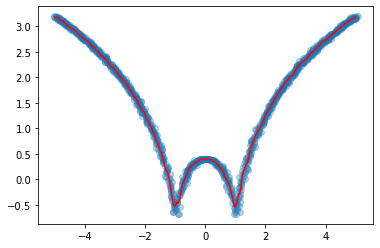

Tau =  5


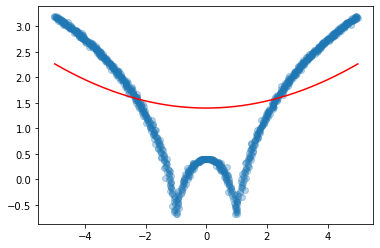

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def radial_kernel(x0, x, tau):
    return np.exp(np.sum((x - x0) ** 2, axis=1) / (-2 * tau ** 2))

def local_regression(x0, x, y, tau):
    x0 = np.r_[1, x0]
    x = np.c_[np.ones(len(x)), x]
    xw = x.T * radial_kernel(x0, x, tau)
    beta = np.linalg.pinv(xw @ x) @ xw @ y
    return x0 @ beta

def plot_lr(tau):
    x = np.linspace(-5, 5, 1000)
    y = np.log(np.abs((x ** 2) - 1) + 0.5)
    x += np.random.normal(scale=0.05, size=1000)

    domain = np.linspace(-5, 5, 1000)
    predictions = [local_regression(x0, x, y, tau) for x0 in domain]
    
    plt.scatter(x, y, alpha=0.3)
    plt.plot(domain, predictions, color="red")
    return plt

print("Tau = ", 0.03)
plot_lr(0.03).show()

print("Tau = ", 5)
plot_lr(5).show()